In [1]:
import os
import cv2
import pydicom
import pandas as pd
import numpy as np 
import random
import tensorflow as tf 
import matplotlib.pyplot as plt 
import random
from tqdm.notebook import tqdm 
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import Model
import seaborn as sns
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers
from tensorflow.keras.layers import LeakyReLU
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from keras.callbacks import ReduceLROnPlateau

# EDA on the data

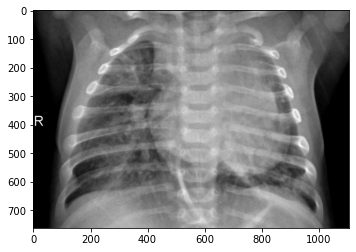

In [3]:
img=cv2.imread('../input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg')
plt.imshow(img)

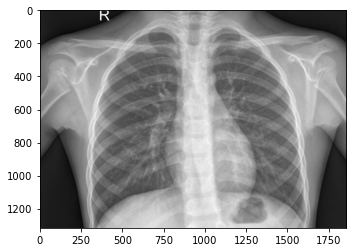

In [4]:
img=cv2.imread('../input/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0001-0001.jpeg')
plt.imshow(img)

In [5]:
train_path='../input/chest-xray-pneumonia/chest_xray/train'
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input,shear_range=0.2,zoom_range=0.2,horizontal_flip=True) \
.flow_from_directory(directory=train_path, target_size=(224,224), classes=['NORMAL', 'PNEUMONIA'], batch_size=32)

val_path='../input/chest-xray-pneumonia/chest_xray/val'
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
.flow_from_directory(directory=val_path, target_size=(224,224), classes=['NORMAL', 'PNEUMONIA'], batch_size=1)

test_path='../input/chest-xray-pneumonia/chest_xray/test'
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
.flow_from_directory(directory=test_path, target_size=(224,224), classes=['NORMAL', 'PNEUMONIA'], batch_size=12)



Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [6]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

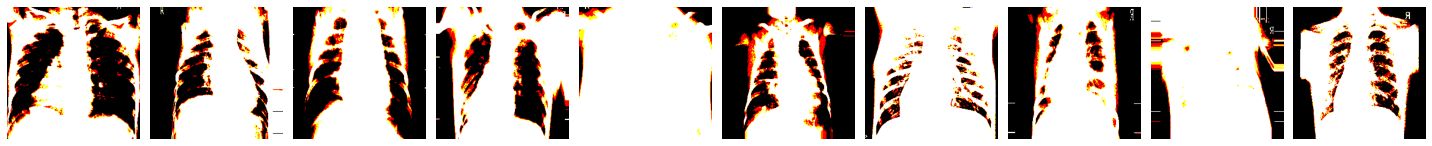

In [7]:
imgs, labels = next(train_batches)
plotImages(imgs)

# Data preprocessing

In [8]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [9]:
train = get_training_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/train')
test = get_training_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/test')
val = get_training_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/val')

OpenCV(4.4.0) /tmp/pip-req-build-dglzv4yn/opencv/modules/imgproc/src/resize.cpp:3929: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.4.0) /tmp/pip-req-build-dglzv4yn/opencv/modules/imgproc/src/resize.cpp:3929: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.4.0) /tmp/pip-req-build-dglzv4yn/opencv/modules/imgproc/src/resize.cpp:3929: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.4.0) /tmp/pip-req-build-dglzv4yn/opencv/modules/imgproc/src/resize.cpp:3929: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



In [10]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [11]:
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [12]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

In [13]:
filepath = "./weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=2, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

# CNN model building 

In [14]:
model=Sequential()
model.add(Conv2D(32 , (3,3) , activation = 'relu' , input_shape = (150,150,1)))
model.add(MaxPool2D((2,2),padding = 'same'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(64 , (3,3),activation = 'relu'))
model.add(MaxPool2D((2,2),padding = 'same'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(128 , (3,3), activation = 'relu'))
model.add(MaxPool2D((2,2),padding = 'same'))
model.add(BatchNormalization())
model.add(Dropout(0.2))


model.add(Conv2D(256,(3,3), activation = 'relu'))
model.add(MaxPool2D((2,2),padding = 'same'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "adam" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()




Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 74, 74, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 36, 36, 64)        2

In [16]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [17]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 12 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/12
163/163 [==============================] - 153s 941ms/step - loss: 0.4264 - accuracy: 0.8606 - val_loss: 8.3895 - val_accuracy: 0.5000
Epoch 2/12
163/163 [==============================] - 148s 909ms/step - loss: 0.2703 - accuracy: 0.8951 - val_loss: 14.5143 - val_accuracy: 0.5000
Epoch 3/12
163/163 [==============================] - ETA: 0s - loss: 0.2307 - accuracy: 0.9091
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 154s 942ms/step - loss: 0.2307 - accuracy: 0.9091 - val_loss: 16.6988 - val_accuracy: 0.5000
Epoch 4/12
163/163 [==============================] - 147s 904ms/step - loss: 0.1860 - accuracy: 0.9285 - val_loss: 8.7288 - val_accuracy: 0.5000
Epoch 5/12
163/163 [==============================] - 148s 911ms/step - loss: 0.1733 - accuracy: 0.9356 - val_loss: 1.0759 - val_accuracy: 0.6875
Epoch 6/12
163/163 [==============================] - 150s 918ms/step - loss: 0.1526 - accuracy: 0.9446

# CNN model Evaluation

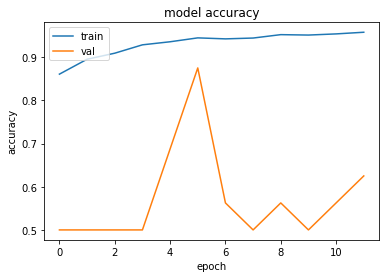

In [21]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

In [18]:
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 4s 184ms/step - loss: 0.2758 - accuracy: 0.8926
Accuracy of the model is -  89.26281929016113 %


In [19]:
predictions = model.predict_classes(x_test)
predictions = predictions.reshape(1,-1)[0]
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.90      0.94      0.92       390
   Normal (Class 1)       0.88      0.82      0.85       234

           accuracy                           0.89       624
          macro avg       0.89      0.88      0.88       624
       weighted avg       0.89      0.89      0.89       624



<Figure size 432x288 with 0 Axes>

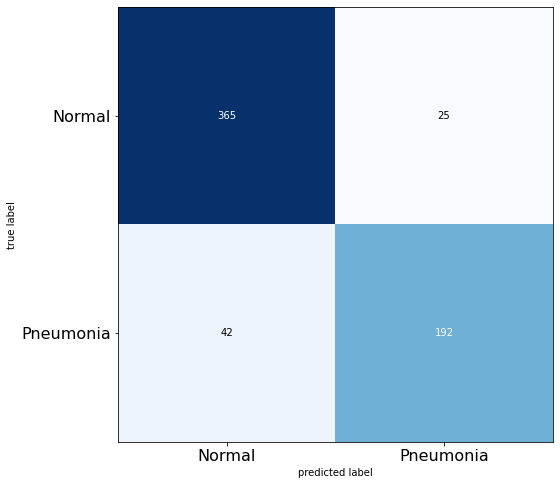

In [20]:
cm  = confusion_matrix(y_test, predictions)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()